In [15]:
%matplotlib inline

In [16]:
from glob import glob
from framed import load_cbmodel
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from framed.io.sbml import sanitize_id
from scipy.stats import pearsonr
import os.path
import seaborn as sns
from carveme import project_dir

In [17]:
sns.set_style('white')
sns.set_palette('deep')

### Load models

In [18]:
files = '../models/gut_models/CarveMe/*.xml.gz'
prefix, suffix = files.split('*')
models = {x[len(prefix):-len(suffix)]: load_cbmodel(x, flavor='cobra')
          for x in glob(files)} 

### Count gap-filled reactions

In [19]:
data = []
for name, model in models.items():
    for r_id, rxn in model.reactions.items():
        if 'GAP_FILL' in rxn.metadata:
            medium = rxn.metadata['GAP_FILL']
            data.append((name, r_id, medium))
            
df = pd.DataFrame(data, columns=['Organism', 'Reaction', 'Medium'])

### Analyse genome size vs gap filled reactions

In [20]:
df2 = pd.read_csv('../models/gut_models/organisms.csv')
df3 = df.groupby('Organism', as_index=False).agg({'Reaction':len})
df2 = pd.merge(df2, df3, on='Organism', how='outer').fillna(0)

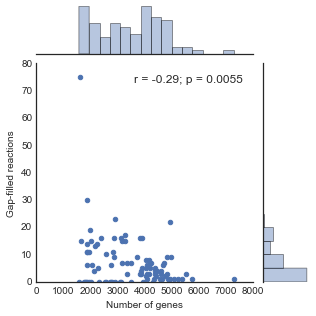

In [21]:
g = sns.jointplot(x= 'Genes', y='Reaction', data=df2,
                  stat_func=pearsonr, annot_kws={'stat': "r"},
                  xlim=(0, 8000), ylim=(0,80),
                  size=4.5, ratio=4, marginal_kws={'bins':15})
g.set_axis_labels('Number of genes', 'Gap-filled reactions')
plt.savefig('../results/other/gut_species1.png', dpi=300)

### Compare with AGORA models

In [22]:
agora = pd.read_excel('../models/gut_models/Tramontano2018.xlsx', sheet_name='S9. Gapfills', 
              skiprows=[0,1], usecols=[0,1,4]).dropna()

agora['Organism'] = agora['designation in screen'].apply(sanitize_id)

agg_f = lambda x: 0 if 'not gapfilled' in list(x) else len(x)

In [23]:
merged = pd.merge(df2, agora.groupby('Organism', as_index=False).agg({'media':agg_f}), 
                  on='Organism').rename(columns={'Reaction': 'CarveMe', 'media': 'AGORA'})

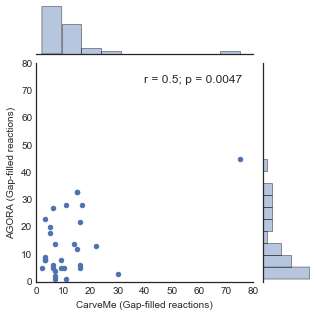

In [24]:
g = sns.jointplot(x= 'CarveMe', y='AGORA', data=merged,
                  stat_func=pearsonr, annot_kws={'stat': "r"},
                  xlim=(0,80), ylim=(0,80), 
                  marginal_kws={'bins':10}, ratio=4, size=4.5)
g.set_axis_labels('CarveMe (Gap-filled reactions)', 'AGORA (Gap-filled reactions)')
plt.savefig('../results/other/gut_species2.png', dpi=300)

### Analyse most gap-filled subsystems

In [25]:
pathways = pd.read_csv(project_dir + '/data/generated/model_specific_data.csv.gz')

pathways = pathways[['reaction', 'subsystem']].dropna()
pathways['reaction'] = pathways.reaction.apply(lambda x: 'R_'+x)

In [26]:
pathways['subsystem'] = pathways.subsystem.str.lower()
pathways = pathways.drop_duplicates()

In [27]:
df4 = pd.merge(df, pathways, left_on='Reaction', right_on='reaction')
df5 = pd.merge(agora, pathways, left_on='reaction ID', right_on='reaction')
df6 = pd.merge(df4['subsystem'].value_counts().reset_index(),
               df5['subsystem'].value_counts().reset_index(),
               on='index').rename(columns={'subsystem_x': 'CarveMe', 'subsystem_y': 'AGORA'})

df6['total'] = df6['CarveMe'] + df6['AGORA']

In [28]:
df6.sort_values('total', ascending=False).head(10)

,index,CarveMe,AGORA,total
0,cofactor and prosthetic group biosynthesis,136,168,304
3,s_coenzymes_and_prosthetic_groups,69,91,160
5,vitamins and cofactor biosynthesis,60,94,154
1,amino acid metabolism,95,40,135
19,vitamins &amp; cofactor biosynthesis,30,79,109
2,s_amino_acids_and_related_molecules,79,29,108
33,porphyrin and chlorophyll metabolism,16,85,101
20,vitamins & cofactor biosynthesis,29,45,74
42,porphyrin metabolism,12,61,73
4,"transport, extracellular",60,3,63
